In [1]:
"""Function definitions that are used in LSB steganography."""
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import binascii
import cv2 as cv
import math
import io
plt.rcParams["figure.figsize"] = (18,10)


def encode_as_binary_array(msg):
    """Encode a message as a binary string."""
    msg = msg.encode("utf-8")
    msg = msg.hex()
    msg = [msg[i:i + 2] for i in range(0, len(msg), 2)]
    msg = [bin(int(el, base=16))[2:] for el in msg]
    msg = ["0" * (8 - len(el)) + el for el in msg]
    return "".join(msg)
    return msg


def decode_from_binary_array(array):
    """Decode a binary string to utf8."""
    array = [array[i:i+8] for i in range(0, len(array), 8)]
    if len(array[-1]) != 8:
        array[-1] = array[-1] + "0" * (8 - len(array[-1]))
    array = [hex(int(el, 2))[2:].zfill(2) for el in array]
    array = "".join(array)
    result = binascii.unhexlify(array)
    return result.decode("utf-8", errors="replace")


def load_image(path, pad=False):
    """Load an image.
    
    If pad is set then pad an image to multiple of 8 pixels.
    """
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    if pad:
        y_pad = 8 - (image.shape[0] % 8)
        x_pad = 8 - (image.shape[1] % 8)
        image = np.pad(
            image, ((0, y_pad), (0, x_pad) ,(0, 0)), mode='constant')
    return image


def save_image(path, image):
    """Save an image."""
    plt.imsave(path, image) 


def clamp(n, minn, maxn):
    """Clamp the n value to be in range (minn, maxn)."""
    return max(min(maxn, n), minn)


def hide_message(image, message, nbits=1):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
#         print(f'{byte} + {chunk} = {new_byte}')
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = 0
    while i < length_in_pixels:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

Marc Chagall - "Me and the village"


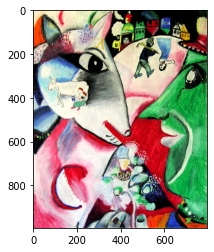

In [2]:
# Zadanie 1
message = "Marc Chagall - \"Me and the village\""
original_image = load_image(path='images/chagall.png')

message = encode_as_binary_array(message)
image_with_message = hide_message(original_image, message, nbits=1)

save_image("images/chagall_with_message.png", image_with_message)
image_with_message_image = load_image(path='images/chagall_with_message.png')

secret_message = decode_from_binary_array(reveal_message(image_with_message, nbits=1, length=len(message)))
plt.imshow(image_with_message_image)
print(secret_message)


In [3]:
# Zadanie 2
def number_of_bytes_in_image(image):
    x,y,z = image.shape
    return x*y*z

def number_of_bits(string):
    return len(string) * 8

def generate_text(text, num_of_bytes, ratio=0.8):
    message = ''
    while (number_of_bits(message) / num_of_bytes < 0.8):
        message += text
    
    return message

num_of_bytes = number_of_bytes_in_image(original_image)
text = generate_text('W4 jest najlepsze! ', num_of_bytes)
print(number_of_bits(text) / num_of_bytes)


0.8000438690845282


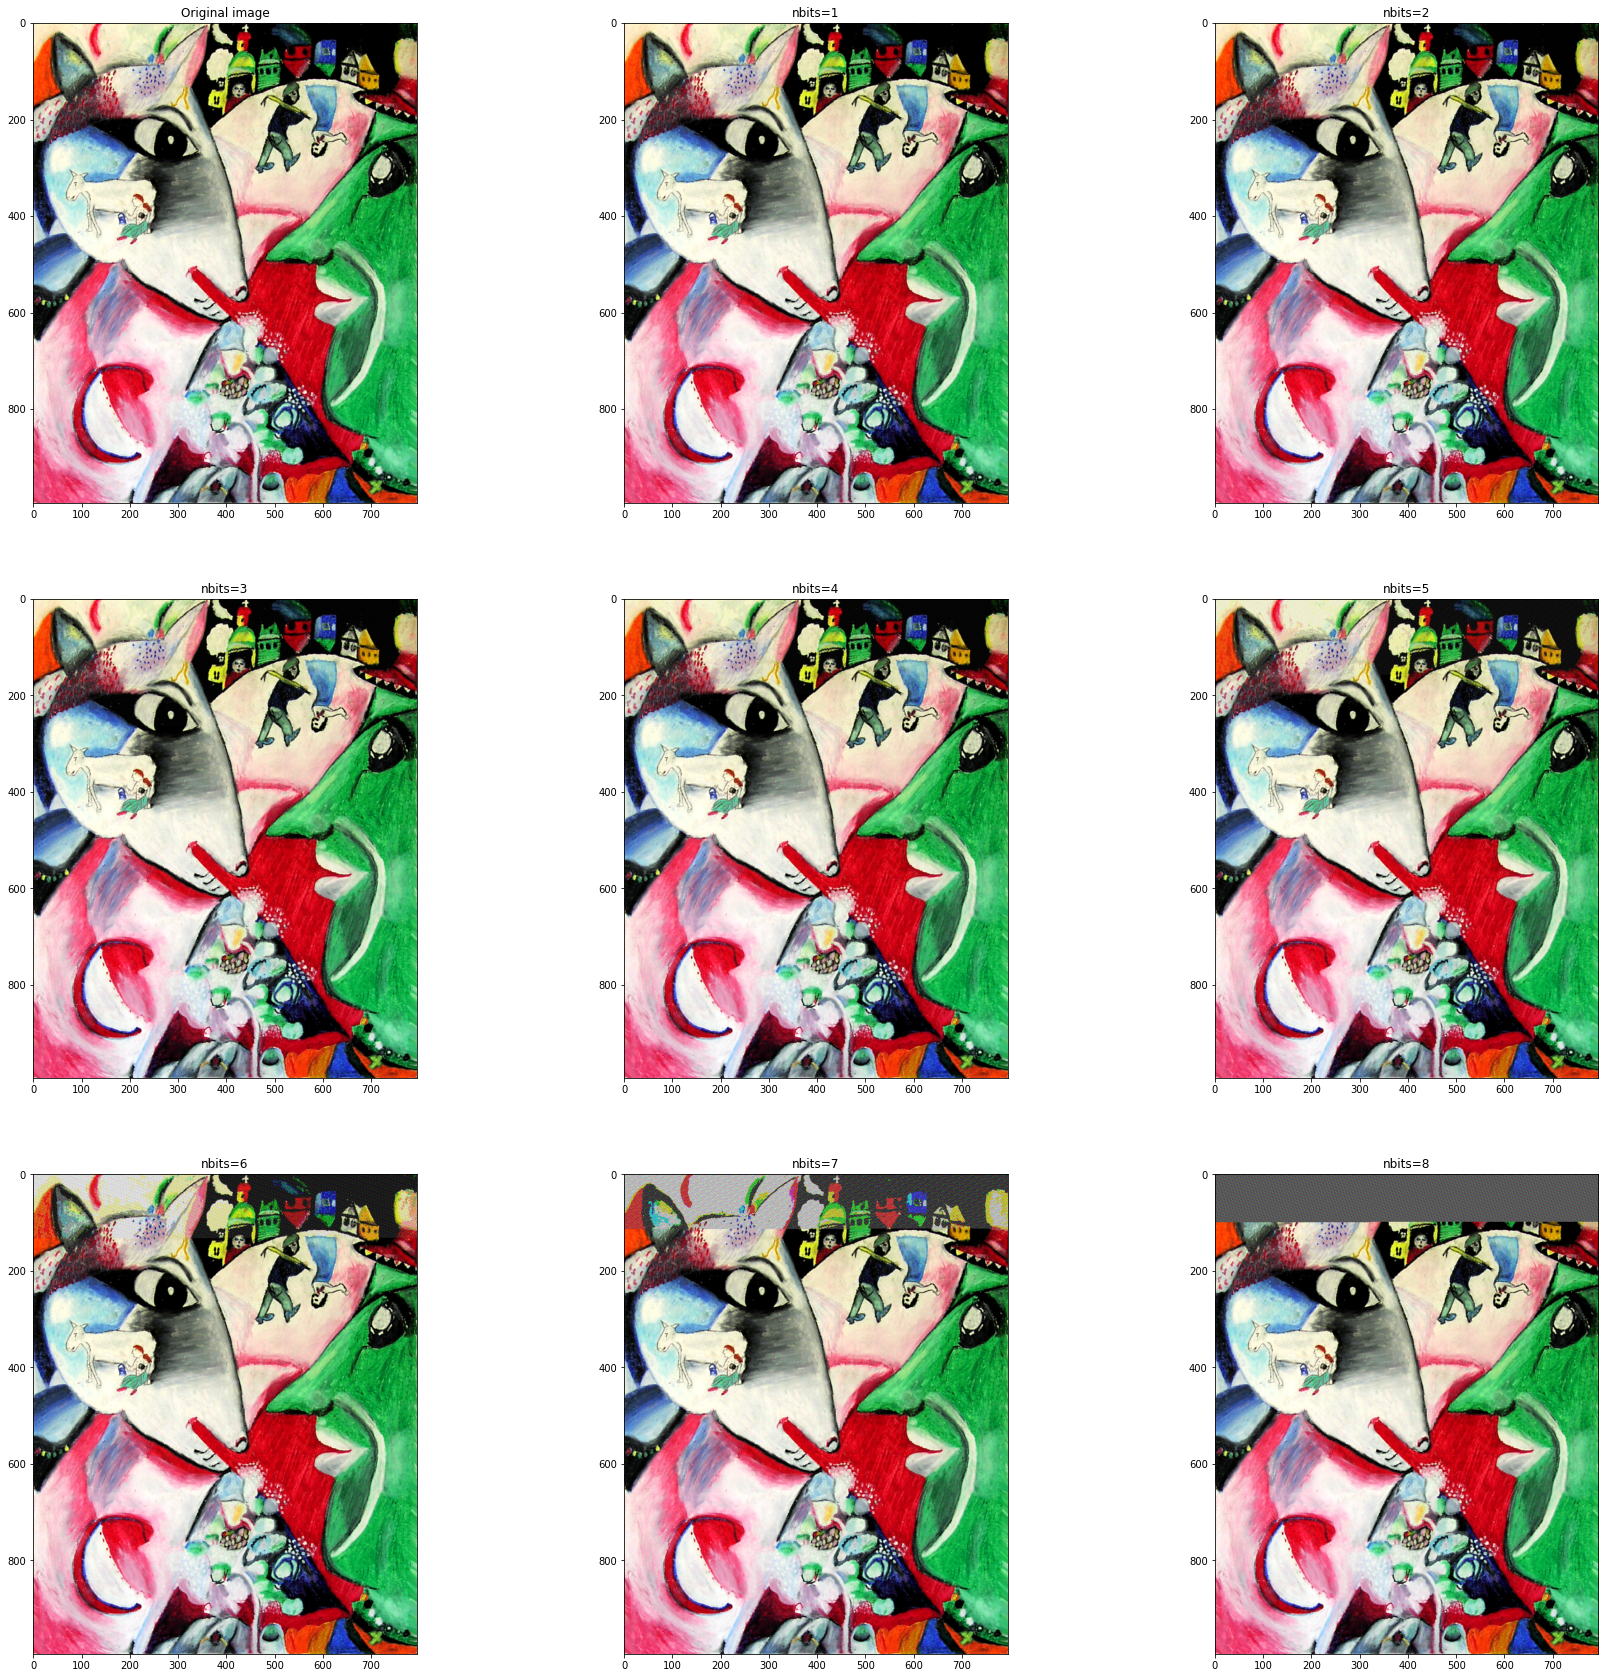

In [4]:
plt.rcParams["figure.figsize"] = (30,30)
message = encode_as_binary_array(text)

images = []
for i in range(1, 9):
    img = hide_message(original_image, message, nbits=i)
    images.append(img)
    save_image(f"images/chagall_with_message_nbits_{i}.png", img)


f, ar = plt.subplots(3,3)
ar[0,0].imshow(original_image)
ar[0,0].set_title("Original image")

ar[0,1].imshow(images[0])
ar[0,1].set_title("nbits=1")

ar[0,2].imshow(images[1])
ar[0,2].set_title("nbits=2")

ar[1,0].imshow(images[2])
ar[1,0].set_title("nbits=3")

ar[1,1].imshow(images[3])
ar[1,1].set_title("nbits=4")

ar[1,2].imshow(images[4])
ar[1,2].set_title("nbits=5")

ar[2,0].imshow(images[5])
ar[2,0].set_title("nbits=6")

ar[2,1].imshow(images[6])
ar[2,1].set_title("nbits=7")

ar[2,2].imshow(images[7])
ar[2,2].set_title("nbits=8")

# works, but makes mess 
# secret_message = decode_from_binary_array(reveal_message(images[6], nbits=7, length=len(message)))
# print(secret_message)

mses = []
for counter, img in enumerate(images):
    mse = np.square(np.subtract(original_image, img)).mean()
    mses.append(mse)


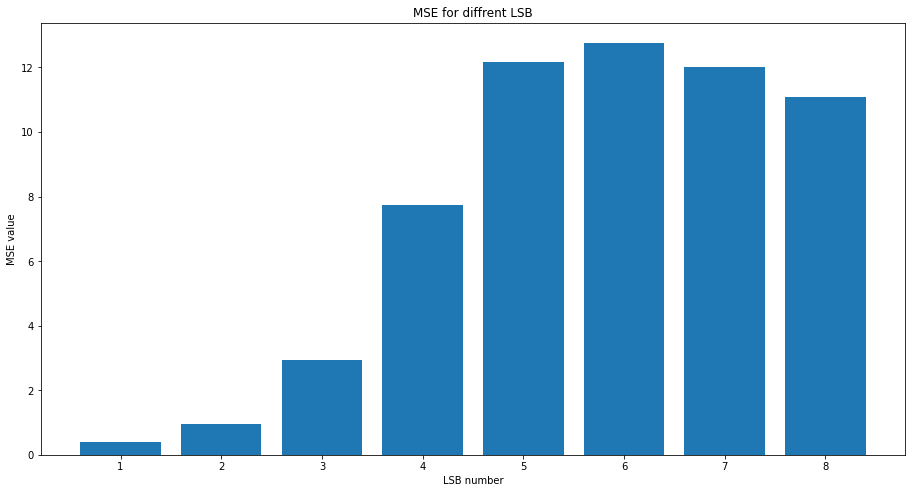

In [5]:
plt.rcParams["figure.figsize"] = (12,6)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(list(range(1,9)), mses)
ax.set_ylabel('MSE value')
ax.set_xlabel('LSB number')
ax.set_title('MSE for diffrent LSB')


plt.show()

In [6]:
# zadanie 3
def hide_message(image, message, nbits=1, spos=0):
    """Hide a message in an image (LSB).
    
    nbits: number of least significant bits
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    if len(message) > len(image) * nbits:
        raise ValueError("Message is to long :(")
    
    chunks = [message[i:i + nbits] for i in range(0, len(message), nbits)]
    for i, chunk in enumerate(chunks, start=spos):
        byte = str(bin(image[i]))[2:].zfill(8)
        new_byte = byte[:-nbits] + chunk
#         print(f'{byte} + {chunk} = {new_byte}')
        image[i] = int(new_byte, 2)
        
    return image.reshape(shape)


def reveal_message(image, nbits=1, length=0, spos=0):
    """Reveal the hidden message.
    
    nbits: number of least significant bits
    length: length of the message in bits.
    """
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length_in_pixels = math.ceil(length/nbits)
    if len(image) < length_in_pixels + spos or length_in_pixels <= 0:
        length_in_pixels = len(image)
    
    message = ""
    i = spos
    while i < length_in_pixels + spos:
        byte = str(bin(image[i]))[2:].zfill(8)
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    return message

Księga pierwsza Gospodarstwo Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy Litwo! Ojczyzno moja! ty jesteś jak zdrowie: Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzę i opisuję, bo tęsknię po tobie.


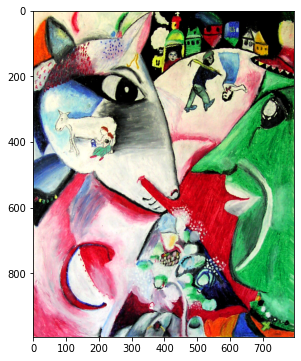

In [7]:
# print(number_of_bytes_in_image(original_image))
message = "Księga pierwsza Gospodarstwo Powrót panicza — Spotkanie się pierwsze w pokoiku, drugie u stołu — Ważna Sędziego nauka o grzeczności — Podkomorzego uwagi polityczne nad modami — Początek sporu o Kusego i Sokoła — Żale Wojskiego — Ostatni Woźny Trybunału — Rzut oka na ówczesny stan polityczny Litwy i Europy Litwo! Ojczyzno moja! ty jesteś jak zdrowie: Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzę i opisuję, bo tęsknię po tobie."
encoded_message = encode_as_binary_array(message)
img = hide_message(original_image, encoded_message, nbits=8, spos=1000000)
plt.imshow(img)
mess = reveal_message(img, nbits=8, length=len(encoded_message), spos=1000000)
print(decode_from_binary_array(mess))

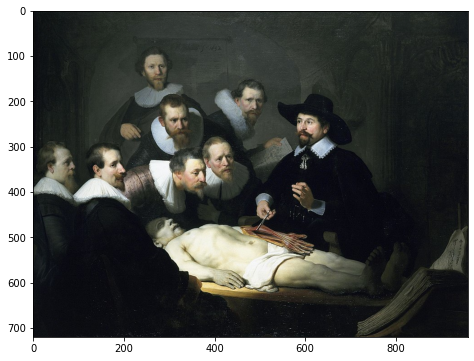

In [8]:
def hide_image(image, secret_image_path, nbits=1):
    with open(secret_image_path, "rb") as file:
        secret_img = file.read()
    
    secret_img = secret_img.hex()
    secret_img = [secret_img[i:i + 2] for i in range(0, len(secret_img), 2)]    
    secret_img = [bin(int(el, base=16))[2:].zfill(8) for el in secret_img]
    secret_img = "".join(secret_img)
    
    return hide_message(image, secret_img, nbits), len(secret_img)

image = load_image("images/rembrandt.png")
image_with_secret, length_of_secret = hide_image(image, "images/spanish.jpg", 1)
plt.imshow(image_with_secret)

In [9]:
# Zadanie 4 i 5

def reveal_image(image, nbits=1):
    nbits = clamp(nbits, 1, 8)
    shape = image.shape
    image = np.copy(image).flatten()
    length = len(image)
    
    message = ""
    i = 0
    while i < length:
        byte = str(bin(image[i]))[2:].zfill(8)
        
        # collecting message through grabbing LSB
        message += byte[-nbits:]
        i += 1
        
    mod = length % -nbits
    if mod != 0:
        message = message[:mod]
    
    # grabbing 8 bits as long as its needed
    message = [message[i:i+8] for i in range(0, len(message), 8)]
    if len(message[-1]) != 8:
        message[-1] = array[-1] + "0" * (8 - len(array[-1]))
    
    # converting to hex bytes in list
    message = [hex(int(el, 2))[2:].zfill(2) for el in message]
    
    # convering to joined hex string
    message = "".join(message)
    
    # splitting by footer, grabbing first, adding footer
    message = message.split('ffd9')[0] + 'ffd9'
    
    # converting to bytes
    result = binascii.unhexlify(message)
    
    # converting from byte-like to real bytes (That's what docs are saying).
    # previous bytes did not work for showing image
    image = Image.open(io.BytesIO(result))
    return image

Did not expect that


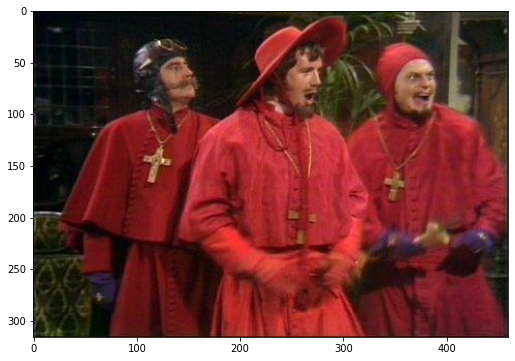

In [10]:
image = reveal_image(image_with_secret, nbits=1)
plt.imshow(image)
print('Did not expect that')

# Zadania

1. (3.0) Korzystając z podanych wyżej funkcji ukryć dowolną wiadomość w dowolnym obrazku.
2. (3.5) Korzystając z kodu znajdującego się w punkcie `Ukryjmy tekst w obrazku` wygenerować i wyświetlić szerego obrazków z ukrytą wiadomością:
    1. Wiadomość dla nbits=1 ma zajmować znakomitą większość obrazka (powyżej 75%).
    2. Każdy kolejny obrazek należy generować z większą wartością nbits (do 8) - będzie 8 obrazków z wiadomością.
    3. Dla każdego obrazka należy policzyć MSE z oryginałem.
    4. Wartości MSE należy umieścić na wykresie (wykres ten należy wyświetlić w notebooku), w którym oś x stanowić będzie nbits.
    5. Źródło tekstu jest dowolne, ale proponuję użyć czegoś w stylu (https://pypi.org/project/lorem/).
    6. Do rysowania wykresu można wykorzystać funkcję `matplotlib.pyplot.plot`
3. (4.0) Przerobić funkcje `reveal_message` i `hide_message` z punktu `Zmiana wartości pikseli` w taki sposób, aby pozwalały zapisywać i odczytywać wiadomość zaczynająć od zadanej pozycji (funkcje można napisać od nowa, ale wyjście ma pozostać niezmienione). Sygnatury funkcji powinny wyglądać następująco (spos to pozycja początkowa):

    1. `def hide_message(image, message, nbits=1, spos=0)`
    2. `def reveal_message(image, nbits=1, length=0, spos=0):`

4. (4.5) Napisać program, który odzyska obrazek z obrazka zapisanego w punkcie 'Ukryjmy obrazek w obrazku'. Funkcja dekodująca (odnajdująca wiadomość) powinna przyjmować następujące parametry: 
    1. image - obrazek z ukrytym obrazkiem
    2. length - długość ukrytego obrazka
    3. nbits - liczba najmłodszych bitów użyta do zakodowania obrazka
5. (5.0) Przekazywanie długości ukrytej wiadomości do funkcji odzyskującej nie jest ładnym rozwiązaniem. W przypadku tajnego tekstu można by było zapisywać na jego końcu znak `\0`, który oznaczałby koniec ciągu znaków. W przypadku ukrytych obrazków można by było wykorzystać standardowy nagłówek i stopkę pliku (i tego dotyczy to zadanie).

    Należy zmodyfikować program napisany w poprzednim punkcie tak, aby funkcja dekodująca nie potrzebowała parametru `length`
    
    Uwagi:
    - w zadaniu wymagane jest jedynie szukanie stopki (plik może być na początku obrazka)
    - istnieje mała szansa, że stopka będzie występowała naturalnie w danych - należy wziąć pozycję pierwszego wystąpnienia (w tym i większości przypadków to zadziała, ale normalnie powinno się dokładniej przeanalizować nagłówek). 